In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg11
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Dataset loader

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import pickle

def save_loaders(train_loader, valid_loader,train_loader_SI, test_loader, file_path):
    loaders = {
        'train_loader': train_loader,
        'valid_loader': valid_loader,
        'train_loader_SI': train_loader_SI,
        'test_loader': test_loader
    }
    with open(file_path, 'wb') as file:
        pickle.dump(loaders, file)

def load_loaders(file_path):
    with open(file_path, 'rb') as file:
        loaders = pickle.load(file)
    return loaders['train_loader'], loaders['valid_loader'], loaders['train_loader_SI'], loaders['test_loader']

def data_loader(batch_size, num_workers=0, random_seed=42, valid_size=0.1, shuffle=True, test=False, save_si=False):

    # Define augmentations
    transform_augmented = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    transform_augmented_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    # Download CIFAR-10 dataset
    if test:
        dataset = datasets.CIFAR10(
            root='./data', train=False,
            download=True, transform=transform_augmented_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )

        return data_loader

    # Load the dataset
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented)

    valid_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    if save_si:
        # Save 10% of training data in a new variable train_loader_SI
        train_si_sampler = SubsetRandomSampler(indices[:int(0.1 * num_train)])
        train_loader_SI = torch.utils.data.DataLoader(
            train_dataset, batch_size=batch_size, sampler=train_si_sampler, num_workers=num_workers)
    else:
        train_si_sampler = None
        train_loader_SI = None

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

    return train_loader, valid_loader, train_loader_SI

# Example usage
train_loader, valid_loader, train_loader_SI = data_loader(batch_size=128, num_workers=1, save_si=True)
test_loader = data_loader(batch_size=128, test=True, num_workers=1)

# Save loaders
save_loaders(train_loader, valid_loader, train_loader_SI,test_loader, 'data_loaders.pkl')

# Load loaders
train_loader, valid_loader,train_loader_SI, test_loader = load_loaders('data_loaders.pkl')

100%|██████████| 170498071/170498071 [00:12<00:00, 13125385.63it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


# Model

In [3]:
import torch.nn as nn

class VGG11(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Example usage:
from torchsummary import summary
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

model = VGG11().to(device)

#summary(model, (3, 32,32))

# Training

In [ ]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda'):
    # Define criterion, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize variables for tracking best accuracy and corresponding model weights
    best_val_acc = 0.0
    best_model_weights = None
    early_stopping_counter = 0

    # Lists to store metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    total_step = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            running_loss += loss.item()

        # Calculate and store training accuracy and loss
        epoch_train_accuracy = 100 * correct_train / total_train
        epoch_train_loss = running_loss / len(train_loader)
        train_acc_list.append(epoch_train_accuracy)
        train_loss_list.append(epoch_train_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Validation
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            val_loss = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            # Calculate validation accuracy
            current_val_acc = 100 * correct / total

            # Store validation loss and accuracy
            val_loss_list.append(val_loss / len(valid_loader))
            val_acc_list.append(current_val_acc)

            # Check if the current accuracy is the best so far
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                # Save the model weights
                best_model_weights = model.state_dict()
                # Reset early stopping counter
                early_stopping_counter = 0
            else:
                # Increment early stopping counter
                early_stopping_counter += 1

            # Check for early stopping
            if early_stopping_counter >= early_stopping_threshold:
                print(f'Early stopping after {early_stopping_counter} epochs without improvement.')
                break

        # Print and save metrics
        print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, epoch_train_loss, epoch_train_accuracy, current_val_acc, val_loss_list[-1]))

    # Print test set accuracy on the best weights
    test_accuracy = test_model(model, test_loader, device)
    print(f'Test Set Accuracy on Best Weights: {test_accuracy:.2f}%')

    # Save the model with the best validation accuracy
    torch.save(best_model_weights, 'best_model_weights.pth')

    # Plot training and validation metrics
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

  0%|          | 1/200 [00:46<2:34:54, 46.71s/it]

Epoch [1/200], Step [352/352], Training Loss: 1.3216, Training Accuracy: 51.99%, Validation Accuracy: 56.12%, Validation Loss: 1.2280


  1%|          | 2/200 [01:37<2:41:07, 48.83s/it]

Epoch [2/200], Step [352/352], Training Loss: 0.9410, Training Accuracy: 66.76%, Validation Accuracy: 66.54%, Validation Loss: 0.9184


  2%|▏         | 3/200 [02:22<2:35:00, 47.21s/it]

Epoch [3/200], Step [352/352], Training Loss: 0.7736, Training Accuracy: 72.88%, Validation Accuracy: 74.28%, Validation Loss: 0.7561


  2%|▏         | 4/200 [03:08<2:33:14, 46.91s/it]

Epoch [4/200], Step [352/352], Training Loss: 0.6805, Training Accuracy: 76.33%, Validation Accuracy: 76.12%, Validation Loss: 0.7283


  2%|▎         | 5/200 [03:53<2:30:25, 46.28s/it]

Epoch [5/200], Step [352/352], Training Loss: 0.6257, Training Accuracy: 78.34%, Validation Accuracy: 75.76%, Validation Loss: 0.6901


  3%|▎         | 6/200 [04:40<2:30:21, 46.50s/it]

Epoch [6/200], Step [352/352], Training Loss: 0.4450, Training Accuracy: 84.65%, Validation Accuracy: 81.94%, Validation Loss: 0.5198


  4%|▎         | 7/200 [05:26<2:28:31, 46.17s/it]

Epoch [7/200], Step [352/352], Training Loss: 0.3976, Training Accuracy: 86.41%, Validation Accuracy: 82.42%, Validation Loss: 0.5057


  4%|▍         | 8/200 [06:13<2:28:39, 46.45s/it]

Epoch [8/200], Step [352/352], Training Loss: 0.3682, Training Accuracy: 87.20%, Validation Accuracy: 82.86%, Validation Loss: 0.4920


  4%|▍         | 9/200 [06:58<2:27:00, 46.18s/it]

Epoch [9/200], Step [352/352], Training Loss: 0.3514, Training Accuracy: 88.00%, Validation Accuracy: 82.48%, Validation Loss: 0.5155


  5%|▌         | 10/200 [07:46<2:27:16, 46.51s/it]

Epoch [10/200], Step [352/352], Training Loss: 0.3317, Training Accuracy: 88.59%, Validation Accuracy: 83.82%, Validation Loss: 0.4867


  6%|▌         | 11/200 [08:31<2:25:36, 46.22s/it]

Epoch [11/200], Step [352/352], Training Loss: 0.2988, Training Accuracy: 89.73%, Validation Accuracy: 83.38%, Validation Loss: 0.5074


  6%|▌         | 12/200 [09:18<2:25:23, 46.40s/it]

Epoch [12/200], Step [352/352], Training Loss: 0.2928, Training Accuracy: 89.96%, Validation Accuracy: 84.14%, Validation Loss: 0.4854


  6%|▋         | 13/200 [10:05<2:24:46, 46.45s/it]

Epoch [13/200], Step [352/352], Training Loss: 0.2911, Training Accuracy: 89.99%, Validation Accuracy: 83.72%, Validation Loss: 0.4655


  7%|▋         | 14/200 [10:52<2:24:29, 46.61s/it]

Epoch [14/200], Step [352/352], Training Loss: 0.2849, Training Accuracy: 90.25%, Validation Accuracy: 83.92%, Validation Loss: 0.4898


  8%|▊         | 15/200 [11:39<2:24:31, 46.88s/it]

Epoch [15/200], Step [352/352], Training Loss: 0.2847, Training Accuracy: 90.24%, Validation Accuracy: 84.36%, Validation Loss: 0.4767


  8%|▊         | 16/200 [12:26<2:23:36, 46.83s/it]

Epoch [16/200], Step [352/352], Training Loss: 0.2778, Training Accuracy: 90.45%, Validation Accuracy: 83.62%, Validation Loss: 0.4721


  8%|▊         | 17/200 [13:12<2:21:49, 46.50s/it]

Epoch [17/200], Step [352/352], Training Loss: 0.2765, Training Accuracy: 90.55%, Validation Accuracy: 84.38%, Validation Loss: 0.4659


  9%|▉         | 18/200 [13:58<2:20:38, 46.36s/it]

Epoch [18/200], Step [352/352], Training Loss: 0.2744, Training Accuracy: 90.57%, Validation Accuracy: 83.48%, Validation Loss: 0.4813


 10%|▉         | 19/200 [14:43<2:18:46, 46.00s/it]

Epoch [19/200], Step [352/352], Training Loss: 0.2763, Training Accuracy: 90.54%, Validation Accuracy: 84.10%, Validation Loss: 0.4868


 10%|█         | 20/200 [15:29<2:18:04, 46.02s/it]

Epoch [20/200], Step [352/352], Training Loss: 0.2754, Training Accuracy: 90.48%, Validation Accuracy: 84.04%, Validation Loss: 0.4726


 10%|█         | 21/200 [16:15<2:17:00, 45.93s/it]

Epoch [21/200], Step [352/352], Training Loss: 0.2755, Training Accuracy: 90.62%, Validation Accuracy: 84.76%, Validation Loss: 0.4847


 11%|█         | 22/200 [17:01<2:16:59, 46.18s/it]

Epoch [22/200], Step [352/352], Training Loss: 0.2741, Training Accuracy: 90.71%, Validation Accuracy: 83.88%, Validation Loss: 0.4739


 12%|█▏        | 23/200 [17:47<2:15:51, 46.05s/it]

Epoch [23/200], Step [352/352], Training Loss: 0.2779, Training Accuracy: 90.54%, Validation Accuracy: 83.74%, Validation Loss: 0.4816


 12%|█▏        | 24/200 [18:33<2:15:05, 46.05s/it]

Epoch [24/200], Step [352/352], Training Loss: 0.2711, Training Accuracy: 90.70%, Validation Accuracy: 84.72%, Validation Loss: 0.4649


 12%|█▎        | 25/200 [19:19<2:13:56, 45.92s/it]

Epoch [25/200], Step [352/352], Training Loss: 0.2753, Training Accuracy: 90.60%, Validation Accuracy: 84.64%, Validation Loss: 0.4646


 13%|█▎        | 26/200 [20:06<2:14:02, 46.22s/it]

Epoch [26/200], Step [352/352], Training Loss: 0.2756, Training Accuracy: 90.55%, Validation Accuracy: 83.90%, Validation Loss: 0.4595


 14%|█▎        | 27/200 [20:52<2:13:45, 46.39s/it]

Epoch [27/200], Step [352/352], Training Loss: 0.2794, Training Accuracy: 90.50%, Validation Accuracy: 84.18%, Validation Loss: 0.4888


 14%|█▍        | 28/200 [21:40<2:14:01, 46.75s/it]

Epoch [28/200], Step [352/352], Training Loss: 0.2734, Training Accuracy: 90.68%, Validation Accuracy: 83.84%, Validation Loss: 0.4657


 14%|█▍        | 29/200 [22:26<2:12:38, 46.54s/it]

Epoch [29/200], Step [352/352], Training Loss: 0.2753, Training Accuracy: 90.47%, Validation Accuracy: 83.88%, Validation Loss: 0.4952


 15%|█▌        | 30/200 [23:13<2:12:16, 46.68s/it]

Epoch [30/200], Step [352/352], Training Loss: 0.2769, Training Accuracy: 90.53%, Validation Accuracy: 83.62%, Validation Loss: 0.4855


 16%|█▌        | 31/200 [23:59<2:10:44, 46.42s/it]

Epoch [31/200], Step [352/352], Training Loss: 0.2740, Training Accuracy: 90.60%, Validation Accuracy: 84.04%, Validation Loss: 0.4741


 16%|█▌        | 32/200 [24:46<2:10:28, 46.60s/it]

Epoch [32/200], Step [352/352], Training Loss: 0.2737, Training Accuracy: 90.70%, Validation Accuracy: 83.92%, Validation Loss: 0.4727


 16%|█▋        | 33/200 [25:32<2:08:55, 46.32s/it]

Epoch [33/200], Step [352/352], Training Loss: 0.2742, Training Accuracy: 90.62%, Validation Accuracy: 83.74%, Validation Loss: 0.4686


 17%|█▋        | 34/200 [26:19<2:09:01, 46.63s/it]

Epoch [34/200], Step [352/352], Training Loss: 0.2788, Training Accuracy: 90.42%, Validation Accuracy: 84.14%, Validation Loss: 0.4667


 18%|█▊        | 35/200 [27:05<2:07:47, 46.47s/it]

Epoch [35/200], Step [352/352], Training Loss: 0.2766, Training Accuracy: 90.63%, Validation Accuracy: 83.72%, Validation Loss: 0.4716


 18%|█▊        | 36/200 [27:51<2:06:56, 46.44s/it]

Epoch [36/200], Step [352/352], Training Loss: 0.2754, Training Accuracy: 90.61%, Validation Accuracy: 84.30%, Validation Loss: 0.4666


 18%|█▊        | 37/200 [28:37<2:05:29, 46.19s/it]

Epoch [37/200], Step [352/352], Training Loss: 0.2762, Training Accuracy: 90.45%, Validation Accuracy: 83.62%, Validation Loss: 0.4751


 19%|█▉        | 38/200 [29:27<2:08:00, 47.41s/it]

Epoch [38/200], Step [352/352], Training Loss: 0.2721, Training Accuracy: 90.56%, Validation Accuracy: 84.74%, Validation Loss: 0.4587


 20%|█▉        | 39/200 [30:14<2:06:38, 47.20s/it]

Epoch [39/200], Step [352/352], Training Loss: 0.2728, Training Accuracy: 90.71%, Validation Accuracy: 84.36%, Validation Loss: 0.4812


 20%|██        | 40/200 [31:02<2:06:49, 47.56s/it]

Epoch [40/200], Step [352/352], Training Loss: 0.2768, Training Accuracy: 90.42%, Validation Accuracy: 83.80%, Validation Loss: 0.4750


 20%|██        | 40/200 [31:49<2:07:19, 47.75s/it]

Early stopping after 20 epochs without improvement.


Test Set Accuracy on Best Weights: 85.20%


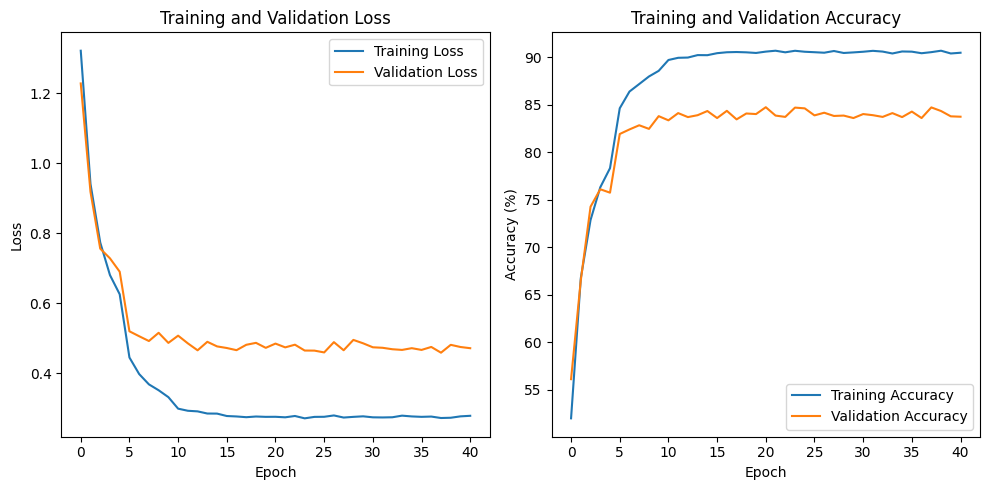

In [ ]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=200, early_stopping_threshold=20, device='cuda:0')

# CSI - Train

In [13]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 800.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

In [13]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11().to(device)
model.load_state_dict(torch.load('all_layers_part_alef.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

VGG11(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [14]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

In [16]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

100%|██████████| 36/36 [00:00<00:00, 113.50it/s]


In [17]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3186.19it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3681.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2986.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4044.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4274.67it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4204.39it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4398.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3990.77it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4219.62it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4403.01it/s]


[('layer1', 0.3878888785839081), ('layer2', 0.4897777736186981), ('layer3', 0.5637778043746948), ('layer4', 0.6348888874053955), ('layer5', 0.7073333263397217), ('layer6', 0.8013333678245544), ('layer7', 0.8707777857780457), ('layer8', 0.8833333253860474), ('fc1', 0.8937777876853943), ('fc2', 0.8823333382606506)]


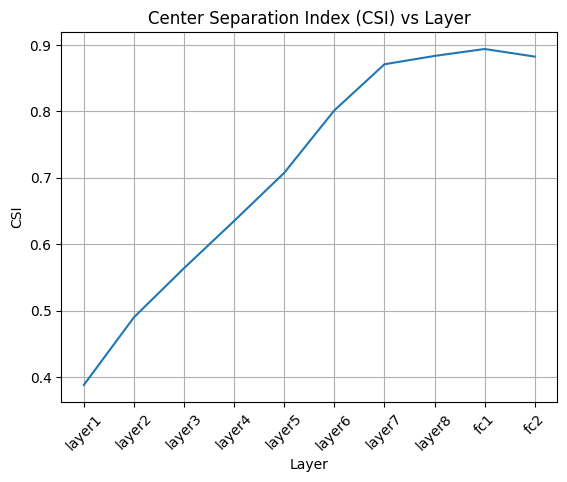

In [18]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

[('layer1', 0.3878888785839081), ('layer2', 0.4897777736186981), ('layer3', 0.5637778043746948), ('layer4', 0.6348888874053955), ('layer5', 0.7073333263397217), ('layer6', 0.8013333678245544), ('layer7', 0.8707777857780457), ('layer8', 0.8833333253860474), ('fc1', 0.8937777876853943), ('fc2', 0.8823333382606506)]


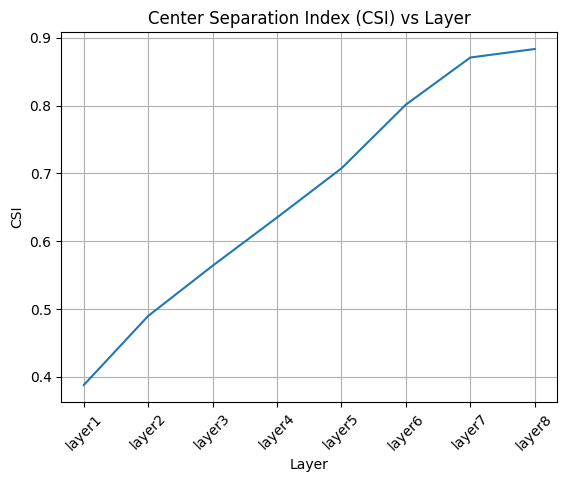

In [19]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI - Test

100%|██████████| 40/40 [00:01<00:00, 31.34it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3322.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4234.96it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3065.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4007.55it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4446.89it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4433.73it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4153.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4068.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4239.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4345.53it/s]

[('layer1', 0.41769999265670776), ('layer2', 0.5157999992370605), ('layer3', 0.5809999704360962), ('layer4', 0.649399995803833), ('layer5', 0.7110999822616577), ('layer6', 0.78329998254776), ('layer7', 0.8319999575614929), ('layer8', 0.8373000025749207), ('fc1', 0.8456999659538269), ('fc2', 0.8379999995231628)]


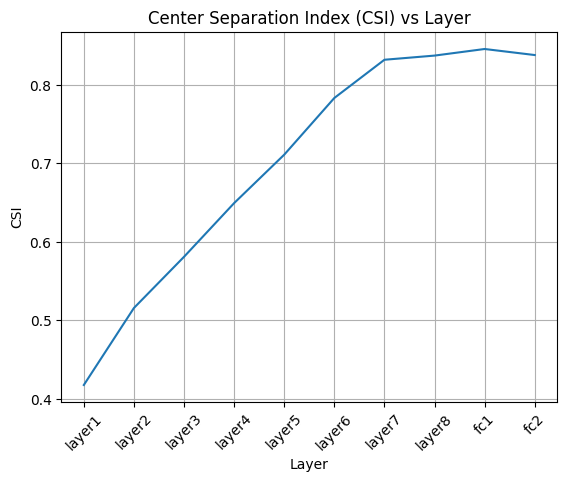

In [21]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11().to(device)
model.load_state_dict(torch.load('all_layers_part_alef.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.41769999265670776), ('layer2', 0.5157999992370605), ('layer3', 0.5809999704360962), ('layer4', 0.649399995803833), ('layer5', 0.7110999822616577), ('layer6', 0.78329998254776), ('layer7', 0.8319999575614929), ('layer8', 0.8373000025749207), ('fc1', 0.8456999659538269), ('fc2', 0.8379999995231628)]


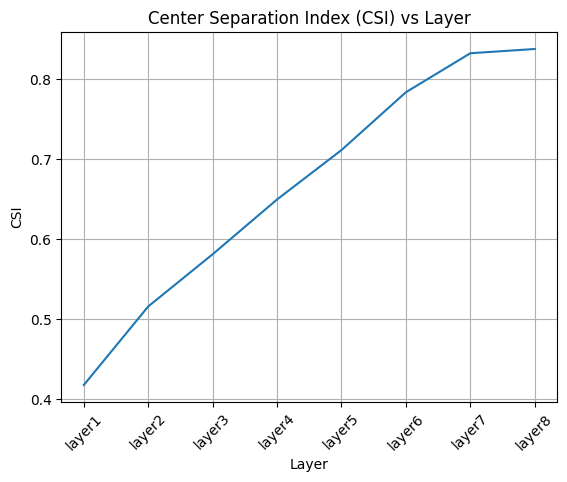

In [22]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('CSI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()